# Seoul Real Estate & Infrastructure Analysis (2025)

## 1. Objective
Analyze the relationship between **2025 Seoul Real Estate Prices** and **Infrastructure Accessibility** (Bus, Subway, Hospital, School, Park).

## 2. Check Environment & Font


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import os

# OS check and Font setting
system_name = platform.system()
if system_name == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else: # Linux
    plt.rc('font', family='NanumGothic')

# Minus sign fix
plt.rcParams['axes.unicode_minus'] = False

print(f"OS: {system_name}")


OS: Darwin


## 3. Data Loading
Load the 6 datasets using `cp949` encoding.


In [2]:
# Paths
data_dir = '../../data'

files = {
    'bus': '버스.csv',
    'hospital': '병원.csv',
    'real_estate': '서울시 부동산 실거래가 정보 2025.csv',
    'subway': '지하철.csv',
    'school': '학교.csv',
    'park': '공원.csv'
}

dfs = {}

for key, filename in files.items():
    path = os.path.join(data_dir, filename)
    try:
        dfs[key] = pd.read_csv(path, encoding='cp949')
        print(f"Loaded {key}: {dfs[key].shape}")
    except Exception as e:
        print(f"Failed to load {key}: {e}")

# Quick Check
for key, df in dfs.items():
    print(f"\n--- {key} ---")
    print(df.head(2))


Loaded bus: (227065, 9)
Loaded hospital: (556, 25)
Loaded real_estate: (127048, 21)


Loaded subway: (289, 7)
Loaded school: (12014, 20)
Loaded park: (18290, 19)

--- bus ---
          정류장번호         정류장명         위도          경도       정보수집일   모바일단축번호  \
0  ADB354000001        길안정류장  36.458658  128.891228  2025-10-31  540001.0   
1  ADB354000002  고란.계명산휴양림입구  36.397708  128.924029  2025-10-31  540002.0   

    도시코드       도시명  관리도시명  
0  37040  경상북도 안동시  안동BIS  
1  37040  경상북도 안동시  안동BIS  

--- hospital ---
   개방자치단체코드                       관리번호       인허가일자  인허가취소일자  영업상태코드  영업상태명  \
0   3220000  PHMA220253220033021200001  2025-04-29      NaN       1  영업/정상   
1   3230000  PHMA220153230034021200002  2015-04-21      NaN       1  영업/정상   

   상세영업상태코드 상세영업상태명  폐업일자  휴업시작일자  ...  \
0        13     영업중   NaN     NaN  ...   
1        13     영업중   NaN     NaN  ...   

                                                지번주소  \
0                                  서울특별시 강남구 논현동 5-4   
1  서울특별시 송파구 문정동 634 가든파이브라이프 10층  L-10001~4, L-1...   

                                              

## 4. Preprocessing & Feature Engineering (Gu-level Aggregation)

### 4.1. Real Estate (Target)
- Filter valid transactions.
- Group by `자치구명` (District) and calculate **Average Transaction Price**.


In [3]:
df_re = dfs['real_estate']

# Check columns
print(df_re.columns)

# Filter for Seoul (Code 11...) if needed, but data seems to be Seoul only based on title
# Group by '자치구명'
# Ensure price column is numeric. '물건금액(만원)'
df_re_gu = df_re.groupby('자치구명')['물건금액(만원)'].mean().reset_index()
df_re_gu.rename(columns={'물건금액(만원)': 'Avg_Price'}, inplace=True)
print(df_re_gu.head())


Index(['접수연도', '자치구코드', '자치구명', '법정동코드', '법정동명', '지번구분', '지번구분명', '본번', '부번',
       '건물명', '계약일', '물건금액(만원)', '건물면적(㎡)', '토지면적(㎡)', '층', '권리구분', '취소일',
       '건축년도', '건물용도', '신고구분', '신고한 개업공인중개사 시군구명'],
      dtype='object')
  자치구명      Avg_Price
0  강남구  217693.536114
1  강동구  105229.196801
2  강북구   45138.600721
3  강서구   59716.133228
4  관악구   62549.374335


### 4.2. Infrastructure Counts by Gu
- Parse addresses to extract `자치구명`.
- Count facilities per Gu.


In [4]:
# Function to extract Gu from address
def extract_gu(address):
    if pd.isna(address):
        return None
    # Address format usually "서울(특별시) XX구 ..."
    tokens = str(address).split()
    for token in tokens:
        if token.endswith('구'):
            return token
    return None

# 1. Hospital
df_hosp = dfs['hospital']
df_hosp['Gu'] = df_hosp['도로명주소'].apply(extract_gu)
hosp_counts = df_hosp.groupby('Gu').size().reset_index(name='Hospital_Count')

# 2. Subway
df_sub = dfs['subway']
# Use '도로명주소' or '지번주소'
df_sub['Gu'] = df_sub['도로명주소'].apply(extract_gu)
sub_counts = df_sub.groupby('Gu').size().reset_index(name='Subway_Count')

# 3. School
df_school = dfs['school']
df_school['Gu'] = df_school['소재지도로명주소'].apply(extract_gu)
school_counts = df_school.groupby('Gu').size().reset_index(name='School_Count')

# 4. Park
df_park = dfs['park']
# Park often has missing addresses, check '소재지도로명주소' or '소재지지번주소'
df_park['Gu'] = df_park['소재지도로명주소'].fillna(df_park['소재지지번주소']).apply(extract_gu)
park_counts = df_park.groupby('Gu').size().reset_index(name='Park_Count')

# 5. Bus
# Bus data (dfs['bus']) often lacks simple address. It has '정류장명', '위도', '경도'.
# Mapping lat/lon to Gu requires reverse geocoding or spatial join.
# For Phase 1, we might SKIP Bus count by Gu unless we have a mapping logic.
# Let's try to see if '도시명' or '관리도시명' helps, or simply omit for Gu-level summary if too complex without shapefiles.
print("Bus data columns:", dfs['bus'].columns)
# Use '도시명' to see if we can filter Seoul
print(dfs['bus']['도시명'].unique()[:10])


Bus data columns: Index(['정류장번호', '정류장명', '위도', '경도', '정보수집일', '모바일단축번호', '도시코드', '도시명',
       '관리도시명'],
      dtype='object')
['경상북도 안동시' '경상북도 예천군' '충청남도 아산시' '충청북도 보은군' '충청남도 보령시' '부산광역시' '경상남도 창원시'
 '충청북도 청주시' '충청남도 천안시' '충청남도 청양군']


## 5. Merging Data
Combine Real Estate Prices with Infrastructure Counts.


In [5]:
# Base: Real Estate Gu
merged_df = df_re_gu.copy()

# Merge all counts
for df_count in [hosp_counts, sub_counts, school_counts, park_counts]:
    # Ensure Gu naming is consistent (e.g. '노원구')
    merged_df = pd.merge(merged_df, df_count, left_on='자치구명', right_on='Gu', how='left')
    # Drop the redundant 'Gu' column from the right immediately
    merged_df.drop(columns=['Gu', 'Gu_x', 'Gu_y'], inplace=True, errors='ignore')

# Fill NaN with 0 (no facility found)
merged_df.fillna(0, inplace=True)
print(merged_df.head())


  자치구명      Avg_Price  Hospital_Count  Subway_Count  School_Count  Park_Count
0  강남구  217693.536114              66            21            80         133
1  강동구  105229.196801              38            15            62          74
2  강북구   45138.600721              17             3            34          54
3  강서구   59716.133228              41             9           117         232
4  관악구   62549.374335              19             4            55          75


## 6. EDA & Correlation Analysis


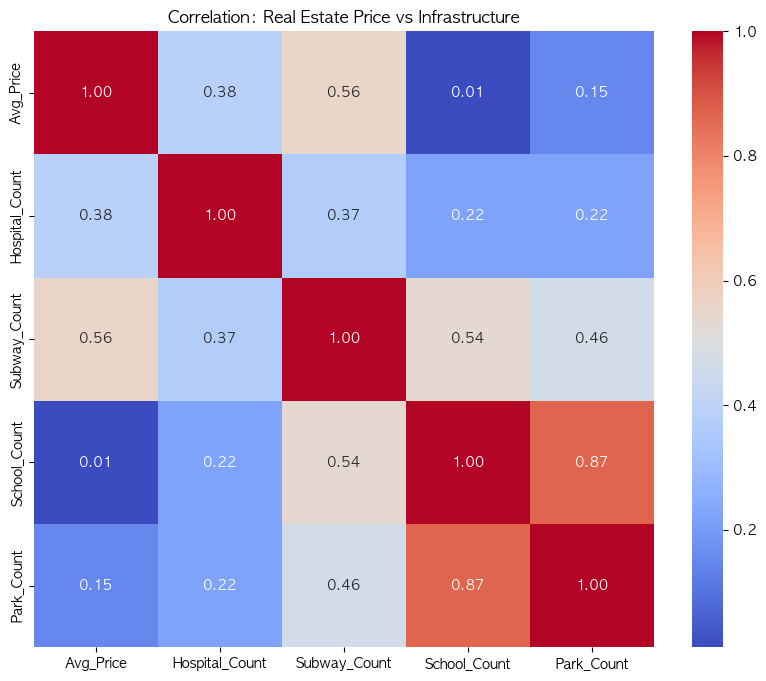

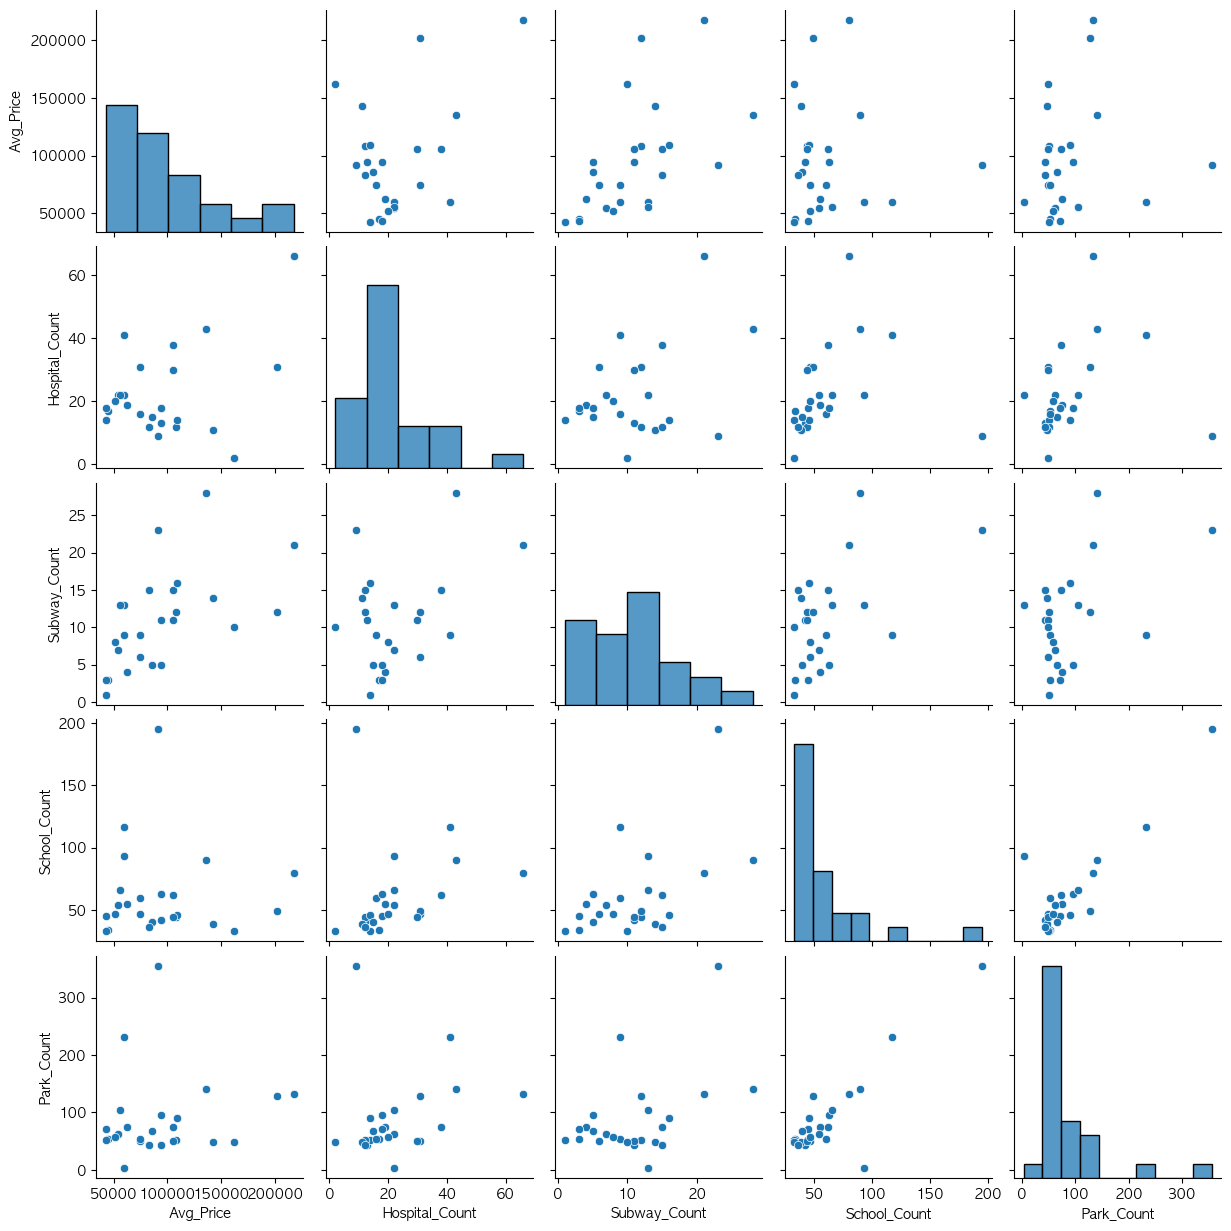

In [6]:
# Correlation Matrix
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Real Estate Price vs Infrastructure')
plt.show()

# Pairplot
sns.pairplot(merged_df)
plt.show()
